# Quick Start: scRNA-seq Data Processing with Scanpy



This notebook is designed for learning basic single-cell RNA-seq (scRNA-seq) data processing workflows using **Scanpy**.



You can run it locally (e.g. in Jupyter) or on **Google Colab**.



---



## Step 1: Open This Notebook in Google Colab (optional)



There is no single fixed link for all users, because it depends on where you store this notebook. Use one of the options below:



### Option A: Upload the notebook file

1. Download this notebook file (`1_Quick_Start_Single_Cell.ipynb`) to your computer.

2. Open Colab: [https://colab.research.google.com](https://colab.research.google.com)

3. In Colab, go to **File → Upload notebook** and select the downloaded file.



### Option B: Open directly from GitHub

1. Make sure this notebook is in a public GitHub repository.

2. Open Colab: [https://colab.research.google.com](https://colab.research.google.com)

3. Click the **GitHub** tab.

4. Paste the GitHub URL of this notebook (from your browser) into the search box.

5. Click the notebook name to open it in Colab.


## Step 2: Install Required Packages



Before starting the analysis, install (or update) the main packages we will use:



- `scanpy` and `anndata` for single-cell analysis and data structures

- `umap-learn` for dimensionality reduction

- `leidenalg` and `python-igraph` for clustering





**Instructions:**



1. If you are on **Colab**, run the next code cell once when you start the notebook.

2. If you are running **locally**, you can either:

   - Use the next cell (it will install into your current environment), or

   - Install these packages with `pip`/`conda` in your environment beforehand.


In [ ]:
# Colab / Environment Setup

# Run this cell once at the start of your session.

# On Google Colab, many core packages are pre-installed, but we

# install or upgrade the key single-cell analysis packages here.



%%capture

!pip install -q \
  scanpy \
  anndata \
  umap-learn \
  leidenalg \
  python-igraph 


In [1]:
import scanpy as sc; sc.set_figure_params(dpi=200)
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns

In [41]:
adata_from_web = sc.read_h5ad('/data/sarkar_lab/Projects/teaching/IGP_S26_single_cell/data/VAL_and_DIS.h5ad')

In [52]:
adata = adata_from_web.raw.to_adata()

## Step 1.1: Make `var_names` Interpretable



Right now, the features in `adata.var_names` may be internal IDs (for example, Ensembl IDs or generic feature IDs), which are not easy to interpret.



In many datasets, `adata.var` also contains a more human-readable column with gene symbols or feature names (for example, a column called `feature_name` or `gene_symbol`).



In the next cell, we:



1. Keep the current IDs in a separate column (`'original_ids'`).

2. Replace `adata.var_names` with a readable feature-name column from `adata.var` (if available).

3. Call `adata.var_names_make_unique()` to avoid duplicate names.


In [53]:
# Try to replace adata.var_names with a more readable feature-name column

# 1. Preserve the original IDs
adata.var['original_ids'] = adata.var_names
# 2. Copy feature names
adata.var_names = adata.var['feature_name'].astype(str)
# 3. Ensure var_names are unique
adata.var_names_make_unique()
adata.var.head()  # Show the updated var table

,feature_name,feature_reference,feature_biotype,feature_length,feature_type,original_ids
feature_name,,,,,,
A1BG,A1BG,NCBITaxon:9606,gene,2301,protein_coding,ENSG00000121410
A1CF,A1CF,NCBITaxon:9606,gene,2211,protein_coding,ENSG00000148584
A2M,A2M,NCBITaxon:9606,gene,590,protein_coding,ENSG00000175899
A2M-AS1,A2M-AS1,NCBITaxon:9606,gene,1809,lncRNA,ENSG00000245105
A2ML1,A2ML1,NCBITaxon:9606,gene,592,protein_coding,ENSG00000166535


In [54]:
adata.raw = adata.copy()

In [55]:
adata.X.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(10696, 28998), dtype=float32)

In [56]:
# normalize, transform, and scale counts
sc.pp.normalize_total(adata)
adata.X = np.arcsinh(adata.X).copy()
sc.pp.scale(adata)

/panfs/accrepfs.vampire/home/sarkah1/miniforge3/envs/spatial/lib/python3.10/functools.py:889: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


In [57]:
adata.X

array([[-0.02866956, -0.09175971, -0.2821998 , ..., -0.06420261,
        -0.0167542 ,  0.        ],
       [-0.02866956, -0.09175971, -0.2821998 , ..., -0.06420261,
        -0.0167542 ,  0.        ],
       [-0.02866956, -0.09175971, -0.2821998 , ..., -0.06420261,
        -0.0167542 ,  0.        ],
       ...,
       [-0.02866956, -0.09175971, -0.2821998 , ..., -0.06420261,
        -0.0167542 ,  0.        ],
       [-0.02866956, -0.09175971, -0.2821998 , ..., -0.06420261,
        -0.0167542 ,  0.        ],
       [-0.02866956, -0.09175971, -0.2821998 , ..., -0.06420261,
        -0.0167542 ,  0.        ]], shape=(10696, 28998))

In [58]:
adata.var_names

Index(['A1BG', 'A1CF', 'A2M', 'A2M-AS1', 'A2ML1', 'A2ML1-AS1', 'A2ML1-AS2',
       'A4GALT', 'A4GNT', 'AAAS',
       ...
       'ZXDC', 'ZYG11A', 'ZYG11B', 'ZYX', 'ZZEF1', 'ZZZ3', 'ENSG00000280372',
       'ENSG00000278932', 'ENSG00000279501', 'LINC01666'],
      dtype='object', name='feature_name', length=28998)

In [59]:
adata.var

,feature_name,feature_reference,feature_biotype,feature_length,feature_type,original_ids,mean,std
feature_name,,,,,,,,
A1BG,A1BG,NCBITaxon:9606,gene,2301,protein_coding,ENSG00000121410,0.000989,0.034493
A1CF,A1CF,NCBITaxon:9606,gene,2211,protein_coding,ENSG00000148584,0.007486,0.081584
A2M,A2M,NCBITaxon:9606,gene,590,protein_coding,ENSG00000175899,0.106373,0.376943
A2M-AS1,A2M-AS1,NCBITaxon:9606,gene,1809,lncRNA,ENSG00000245105,0.000488,0.020662
A2ML1,A2ML1,NCBITaxon:9606,gene,592,protein_coding,ENSG00000166535,0.001672,0.038880
...,...,...,...,...,...,...,...,...
ZZZ3,ZZZ3,NCBITaxon:9606,gene,686,protein_coding,ENSG00000036549,0.105845,0.320719
ENSG00000280372,ENSG00000280372,NCBITaxon:9606,gene,1495,TEC,ENSG00000280372,0.000146,0.011147
ENSG00000278932,ENSG00000278932,NCBITaxon:9606,gene,964,lncRNA,ENSG00000278932,0.004102,0.063895


In [60]:
adata.var['Mitochondrial'] = adata.var.index.str.startswith('mt-')
sc.pp.calculate_qc_metrics(adata,qc_vars=['Mitochondrial'],use_raw=True,inplace=True)

In [61]:
sc.pp.pca(adata,random_state=0)

In [62]:
neighborhood_k = np.sqrt(adata.n_obs).astype(int)  # We have found that scaling the K to equal the square root of the total number of neighbors to be effective
sc.pp.neighbors(adata,n_neighbors=neighborhood_k,use_rep='X_pca',random_state=0)  # Calculate this KNN based off of the PCA distances
sc.tl.leiden(adata,resolution=0.5,random_state=0)  # Here we use a resolution of 2, which should yield 30+ clusters. This step may take a while.

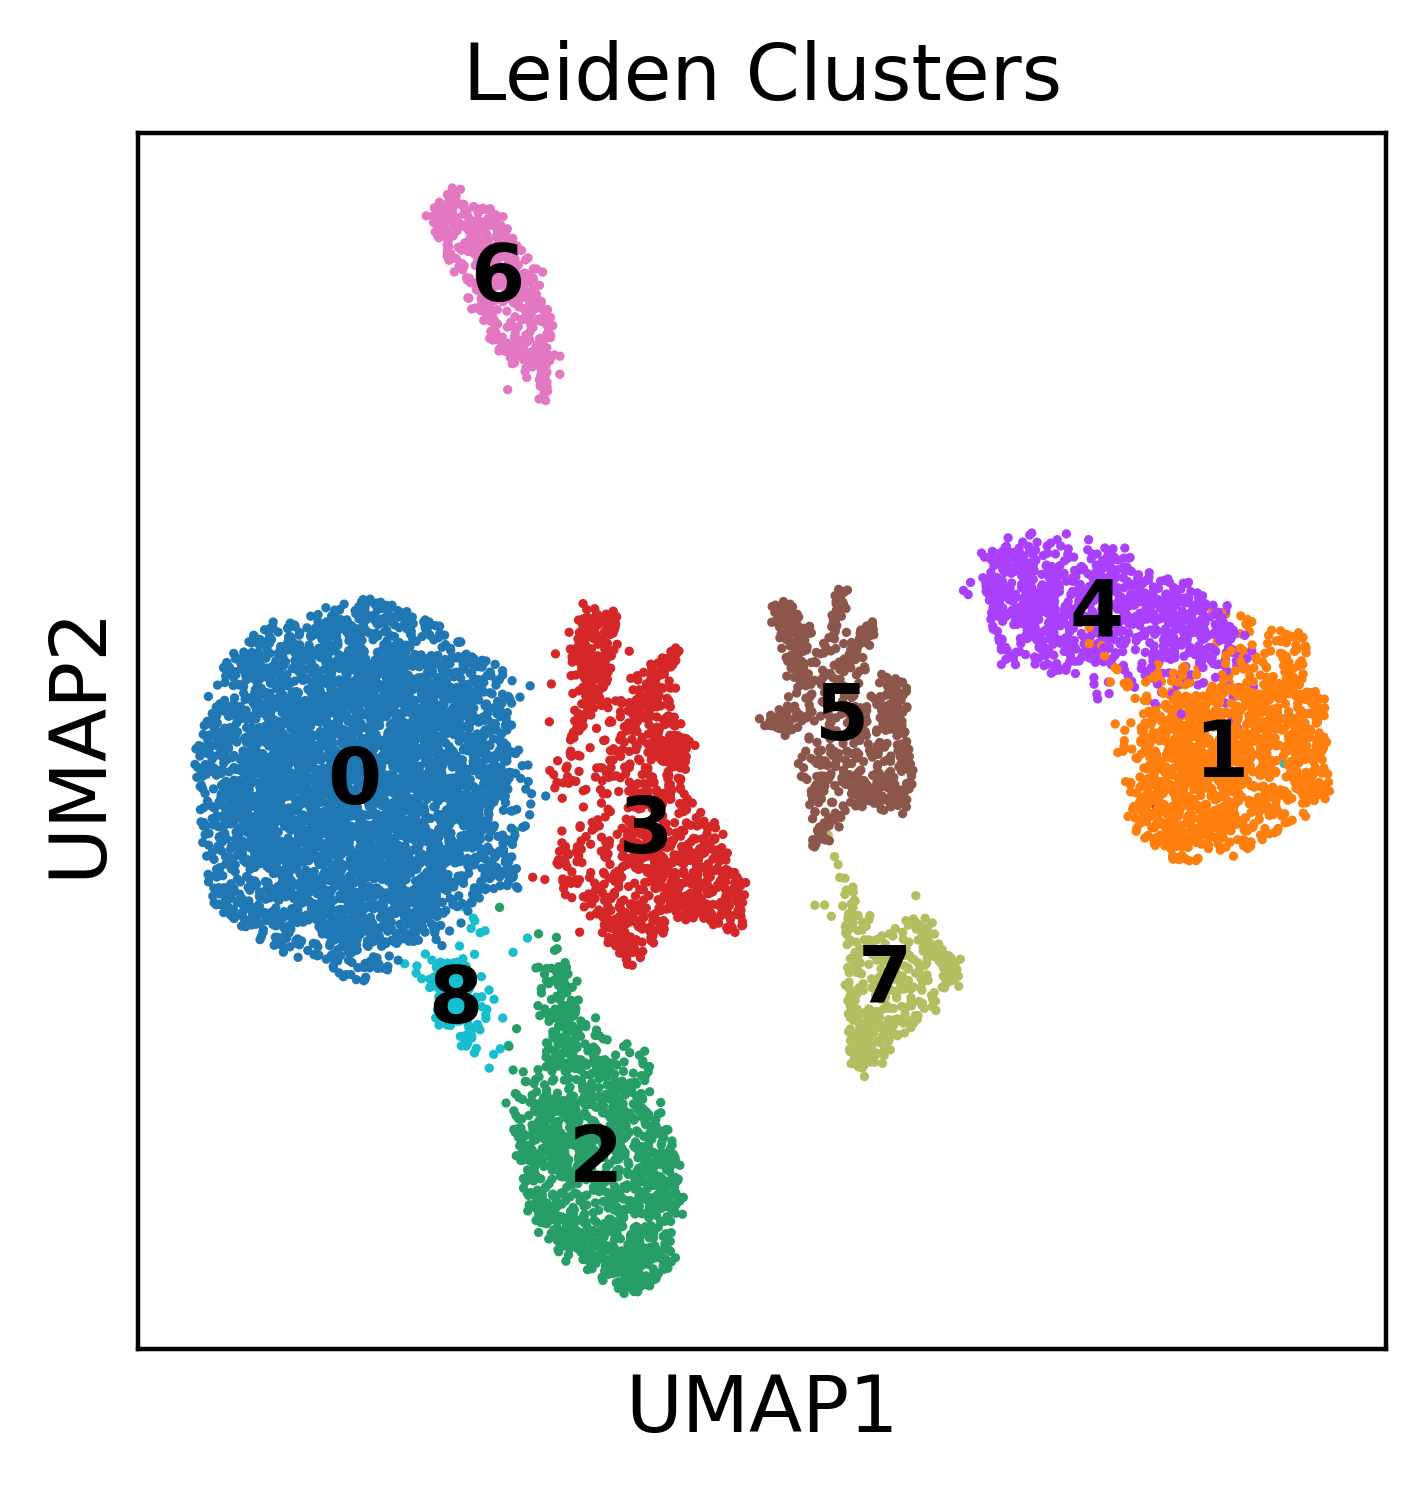

In [63]:
# UMAP visualization
sc.tl.umap(adata,random_state=0)
sc.pl.umap(adata,color=['leiden'],legend_loc='on data',title='Leiden Clusters')

In [64]:
# Differential gene expression testing using the .raw values
sc.tl.rank_genes_groups(adata,groupby='leiden',use_raw=True,n_genes=200,method='wilcoxon')

/panfs/accrepfs.vampire/home/sarkah1/miniforge3/envs/spatial/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:479: RuntimeWarning: overflow encountered in expm1
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (
/panfs/accrepfs.vampire/home/sarkah1/miniforge3/envs/spatial/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:479: RuntimeWarning: overflow encountered in expm1
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (


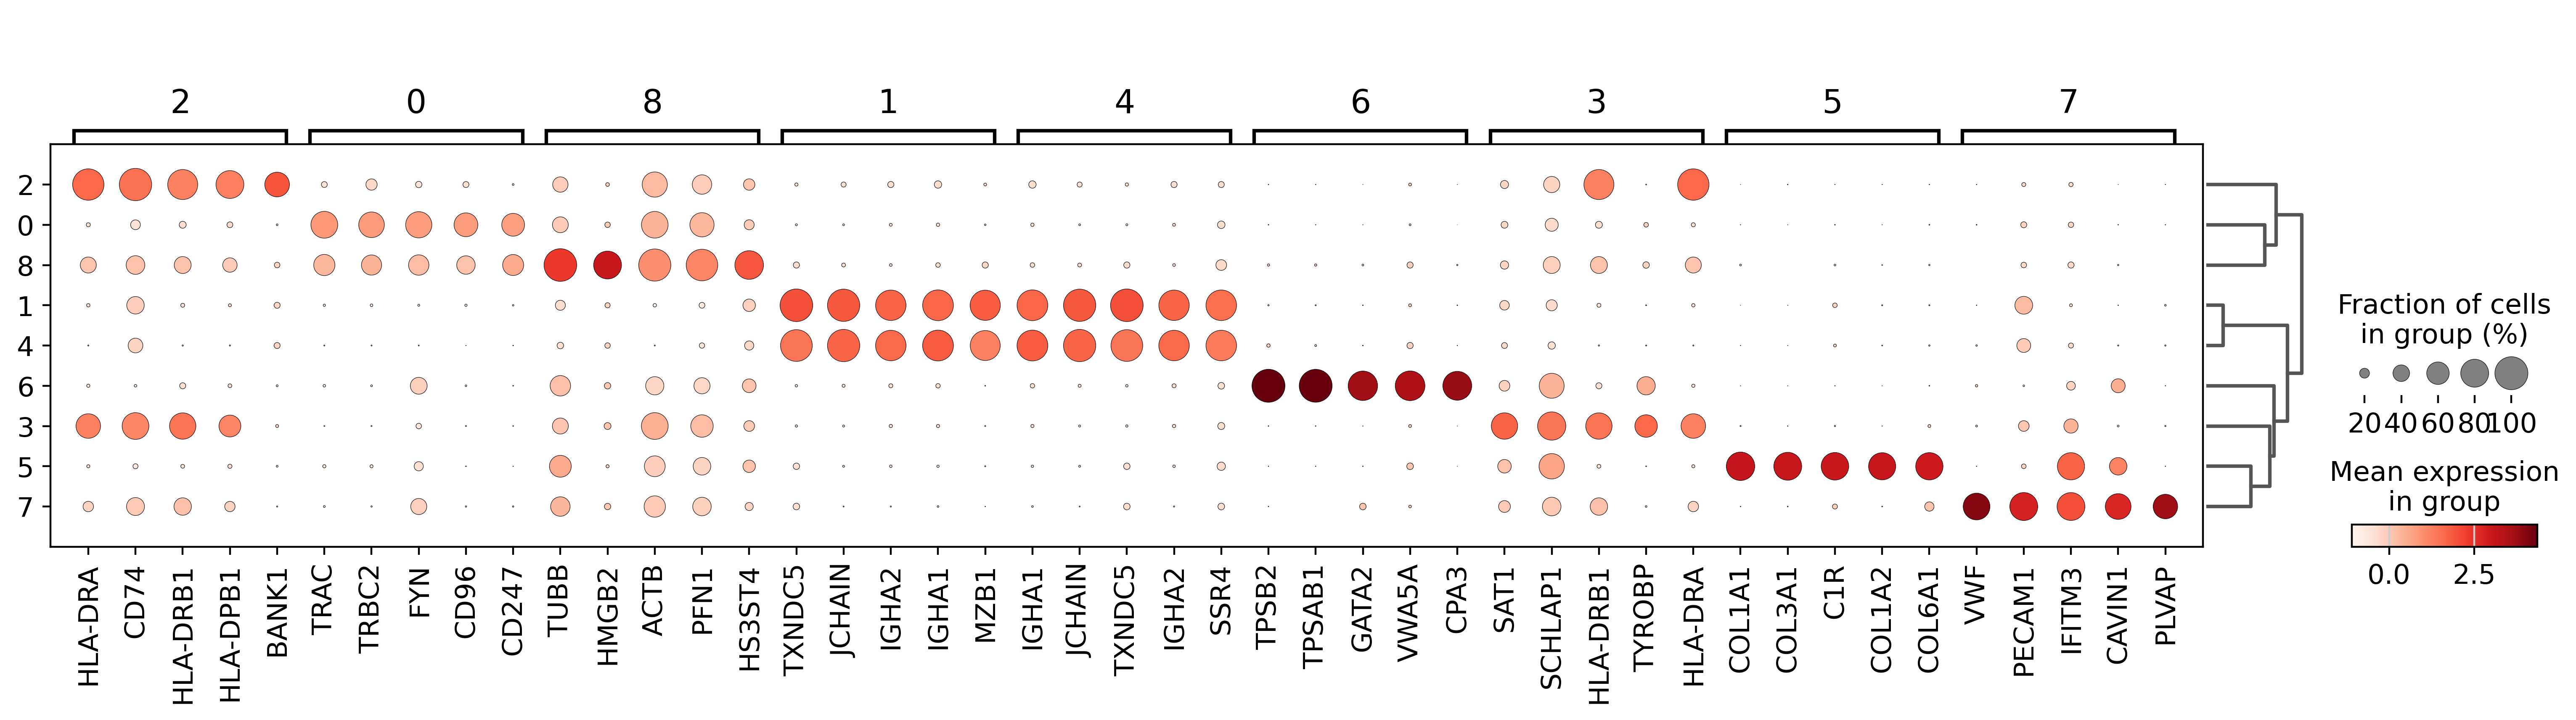

In [65]:
sc.pl.rank_genes_groups_dotplot(adata, n_genes=5, use_raw=False)

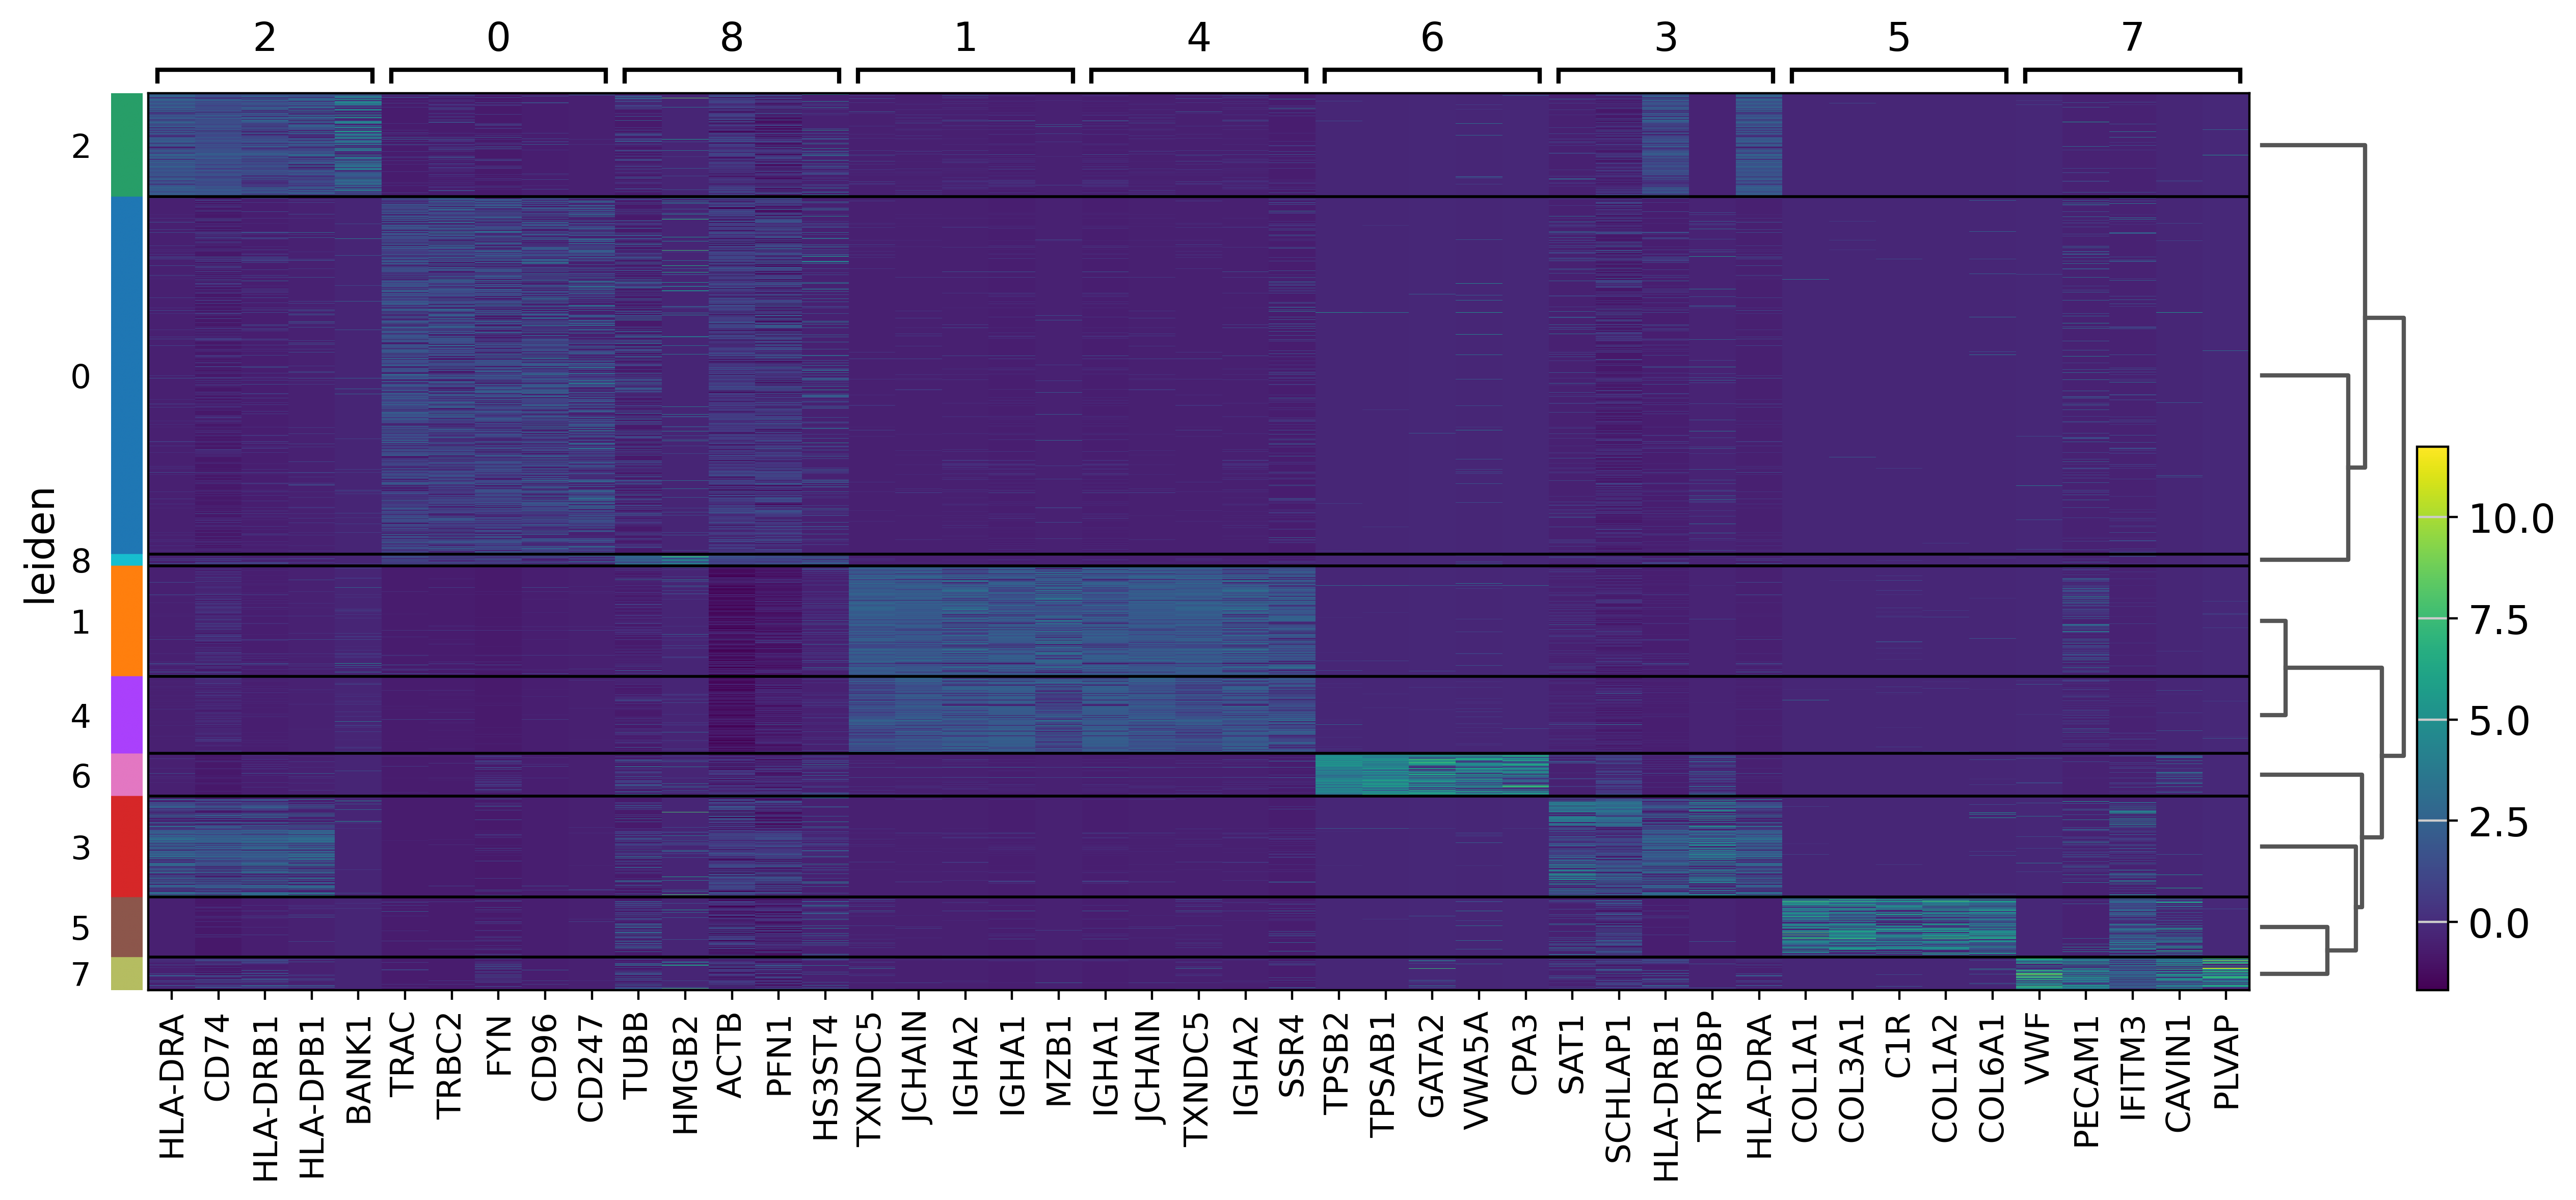

In [66]:
sc.pl.rank_genes_groups_heatmap(adata, n_genes=5, show_gene_labels=True, use_raw=False)